# Gas Powered (Medium Altitude Long Endurace) Aicraft

This notebook is an interactive tool to understand the design space of a medium altitude long endurance aircraft.

Import necessary modules.

In [1]:
from numpy import pi
import matplotlib.pyplot as plt
from gpkit import VectorVariable, Variable, Model, units
from gpkit.tools import te_exp_minus1
from gpkit import LinkedConstraintSet
from gpkit.constraints.set import ConstraintSet
import gpkit
import numpy as np
gpkit.settings['latex_modelname'] = False

### Define number of flight segments

In [2]:
NSeg = 9 # number of flight segments
NCruise = 2 # number of cruise segments
NClimb = 2 # number of climb segments
NLoiter = NSeg - NCruise - NClimb # number of loiter segments
iCruise = [1, -1] # cuise index
iLoiter = [3] # loiter index
for i in range(4, NSeg-1): iLoiter.append(i)
iClimb = [0, 2] # climb index

### Objective Function Variables

In [5]:
t_station = Variable('t_{station}', 'days', 'time on station')
MTOW = Variable('MTOW', 100, 'lbf', 'max take off weight')

## Altitude Model

Assumed that the loiter and cruise altitudes are constant and that the climb rate has to be at least 100 ft/min.

In [39]:
class Altitude(ConstraintSet):
    def __init__(self, **kwargs):
        
        # Constants
        h_dotmin = Variable('h_{dot-min}', 100, 'ft/min', 'minimum necessary climb rate')
        h_station = Variable('h_{station}', 15000, 'ft', 'minimum altitude at station')
        h_cruise = Variable('h_{cruise}', 5000, 'ft', 'minimum cruise altitude')
        deltah = Variable(r'\delta_h', h_station.value-h_cruise.value, 'ft', 'delta height') 
        
        # System Variables
        h = VectorVariable(NSeg, 'h', 'ft', 'altitude')
        t = VectorVariable(NSeg, 't', 'days', 'time per flight segment')
        h_dot = VectorVariable(NClimb, 'h_{dot}', 'ft/min', 'Climb rate')
        
        constraints = [t[iClimb[0]]*h_dot[0] >= h_cruise, 
                       t[iClimb[1]]*h_dot[1] >= deltah,
                       h[iClimb[0]] == h_cruise,
                       h[iClimb[1]] == h_station,
                       h[iCruise] == h_cruise,
                       h[iLoiter] == h_station,
                       h_dot >= h_dotmin]
        
        ConstraintSet.__init__(self, constraints, **kwargs)
        

## Atmospheric Model

This is only valid up to 7km.   Assumes that density decreases with altitude.

In [40]:
class Atmosphere(ConstraintSet):
    def __init__(self, **kwargs):
        
        #Constants
        mu_sl = Variable(r'\mu_{sl}', 1.789*10**-5, 'N*s/m^2','Dynamic viscosity at sea level')
        h_ref = Variable('h_{ref}', 15000, 'ft', 'ref altitude')
        h_station = Variable('h_{station}', 15000, 'ft', 'minimum altitude at station')
        h_cruise = Variable('h_{cruise}', 5000, 'ft', 'minimum cruise altitude')
        p_sl = Variable('p_{sl}', 101325, 'Pa', 'Pressure at sea level')
        T_sl = Variable('T_{sl}', 288.15, 'K', 'Temperature at sea level')
        L_atm = Variable('L_{atm}', 0.0065, 'K/m', 'Temperature lapse rate')
        T_atm = VectorVariable(2, 'T_{atm}', [T_sl.value - L_atm.value*h_cruise.value, 
                                              T_sl.value - L_atm.value*h_station.value], 'K', 'Air temperature')        
        R_spec = Variable('R_{spec}', 287.058, 'J/kg/K', 'Specific gas constant of air')
                
        # System Variables
        mu_atm = VectorVariable(NSeg,r'\mu', 'N*s/m^2', 'Dynamic viscosity')
        h = VectorVariable(NSeg, 'h', 'ft', 'altitude')
        rho = VectorVariable(NSeg, r'\rho', 'kg/m^3', 'air density')   

        constraints = [rho[iClimb[0]] == p_sl*T_atm[0]**(4.257)/R_spec/(T_sl**5.257),
                       rho[iCruise] == p_sl*T_atm[0]**(4.257)/R_spec/(T_sl**5.257),
                       rho[iClimb[1]] == p_sl*T_atm[1]**(4.257)/R_spec/(T_sl**5.257),
                       rho[iLoiter] == p_sl*T_atm[1]**(4.257)/R_spec/(T_sl**5.257),
                       (mu_atm/mu_sl)**0.1 == 0.991*(h/h_ref)**(-0.00529)]
        
        ConstraintSet.__init__(self, constraints, **kwargs)

## Fuel Weight Model

Assumes that the at the eng of each flight segment the weight ($W_{end}$) must be the weight it was at the beginning of the segment ($W_{begin}$) minus the amount of fuel that it spent ($W_{fuel}$). 

In [41]:
class FuelWeight(ConstraintSet):
    def __init__(self, **kwargs):
        
        #System Variables
        W_end = VectorVariable(NSeg, 'W_{end}', 'lbf', 'segment-end weight')
        W_fuel = VectorVariable(NSeg, 'W_{fuel}', 'lbf', 'segment-fuel weight')
        W_zfw = Variable('W_{zfw}', 'lbf', 'Zero fuel weight')
        W_begin = W_end.left # define beginning of segment weight
        W_begin[0] = MTOW
        
        constraints = [MTOW >= W_end[0] + W_fuel[0], 
                       W_end[:-1] >= W_end[1:] + W_fuel[1:], 
                       W_end[-1] >= W_zfw]
        
        ConstraintSet.__init__(self, constraints, **kwargs)

## Steady Level Flight Condition

Assumes that the aircraft is always flying under a steady level flight condition.  When the aircraft is climbing, the thrust, and therefore the power, is constrained to account for additional thrust/power needed to climb at the specified rate.  Also assumes different propulsive efficiency for each leg of the flight.

In [42]:
class SteadyLevelFlight(ConstraintSet):
    def __init__(self, **kwargs):

        # Constants
        eta_propCruise = Variable(r'\eta_{prop-cruise}',0.6,'-','propulsive efficiency in cruise')
        eta_propClimb = Variable(r'\eta_{prop-climb}',0.5,'-','propulsive efficiency in climb')
        eta_propLoiter = Variable(r'\eta_{prop-loiter}',0.7,'-','propulsive efficiency in loiter')
        h_dotmin = Variable('h_{dot-min}', 100, 'ft/min', 'minimum necessary climb rate')
        
        # Free Variables
        eta_prop = VectorVariable(NSeg, r'\eta_{prop}', '-', 'propulsive efficiency')
        T = VectorVariable(NSeg, 'T', 'lbf', 'Thrust')
        
        #System Varibles
        CD = VectorVariable(NSeg, 'C_D', '-', 'Drag coefficient')
        CL = VectorVariable(NSeg, 'C_L', '-', 'Lift coefficient')
        V = VectorVariable(NSeg, 'V', 'm/s', 'cruise speed')
        S = Variable('S', 'ft^2', 'wing area')
        rho = VectorVariable(NSeg, r'\rho', 'kg/m^3', 'air density')   
        W_end = VectorVariable(NSeg, 'W_{end}', 'lbf', 'segment-end weight')
        W_begin = W_end.left # define beginning of segment weight
        W_begin[0] = MTOW
        P_shaft = VectorVariable(NSeg, 'P_{shaft}', 'hp', 'Shaft power')
        h_dot = VectorVariable(NClimb, 'h_{dot}', 'ft/min', 'Climb rate')
     
        constraints = [P_shaft == T*V/eta_prop, 
                       T >= 0.5*rho*V**2*CD*S, 
                       T[iClimb] >= 0.5*rho[iClimb]*V[iClimb]**2*CD[iClimb]*S + 
                                    W_begin[iClimb]*h_dot/V[iClimb], 
                       0.5*rho*CL*S*V**2 == (W_end*W_begin)**0.5,
                       eta_prop[iLoiter] == eta_propLoiter,
                       eta_prop[iCruise] == eta_propCruise,
                       eta_prop[iClimb] == eta_propClimb]
        
        ConstraintSet.__init__(self, constraints, **kwargs)

## Engine Model (DF35)

This engine model assumes that the engine is small.  The sizing to power curve is based off a sample of small engines that are two-stroke, four-stroke, and turboprop.  The engine accessory weight curve comes from Raymer.  The BSFC curves come from the manufacturing test data of the DF35 engine.  The avionics power comes from an estimate for basic avionics plus payload power consumption. 

In [43]:
class Engine(ConstraintSet):
    def __init__(self, **kwargs):
        
        # Constants
        W_engref = Variable('W_{eng-ref}', 4.4107, 'lbf', 'Reference engine weight')
        P_shaftref = Variable('P_{shaft-ref}', 2.295, 'hp', 'reference shaft power')
        BSFC_min = Variable('BSFC_{min}', 0.32, 'kg/kW/hr', 'Minimum BSFC')        
        RPM_max = Variable('RPM_{max}', 9000, 'rpm', 'Maximum RPM')
        P_avn = Variable('P_{avn}', 40, 'watts', 'avionics power')
        P_pay = Variable('P_{pay}', 10, 'watts', 'payload power')
        h_ref = Variable('h_{ref}', 15000, 'ft', 'ref altitude')
        eta_alternator = Variable(r'\eta_{alternator}', 0.8, '-', 'alternator efficiency')
        
        # Free Variables
        W_eng = Variable('W_{eng}', 'lbf', 'engine weight')
        RPM = VectorVariable(NSeg, 'RPM', 'rpm', 'Engine operating RPM')
        P_shaftmax = VectorVariable(NSeg, 'P_{shaft-max}', 'hp', 
                                    'Max shaft power at altitude')
        P_shaftmaxMSL = Variable('P_{shaft-maxMSL}', 'hp', 'Max shaft power at MSL')
        Lfactor = VectorVariable(NSeg, 'L_factor', '-', 'Max shaft power loss factor')
        
        # System Variables
        W_engtot = Variable('W_{eng-tot}', 'lbf', 'Installed engine weight')
        BSFC = VectorVariable(NSeg, 'BSFC', 'lb/hr/hp', 'brake specific fuel consumption')
        P_shafttot = VectorVariable(NSeg, 'P_{shaft-tot}', 'hp', 'total power need including power draw from avionics')
        P_shaft = VectorVariable(NSeg, 'P_{shaft}', 'hp', 'Shaft power')
        h = VectorVariable(NSeg, 'h', 'ft', 'altitude')
        
        # Engine Weight Constraints
        constraints = [# engine loss factor constraints
                       Lfactor == 0.906**(1/0.15)*(h/h_ref)**0.92, 
                       P_shaftmax/P_shaftmaxMSL + Lfactor <= 1, 
                       P_shaftmax[iCruise] >= P_shaftmaxMSL*.81,
                       P_shaftmax[iClimb[0]] >= P_shaftmaxMSL*.81,
                       P_shaftmax[iClimb[1]] >= P_shaftmaxMSL*0.481,
                       P_shaftmax[iLoiter] >= P_shaftmaxMSL*0.481,
                       # engine weight constraints
                       W_eng/W_engref >= 0.5538*(P_shaftmaxMSL/P_shaftref)**1.075, 
                       W_engtot >= 2.572*W_eng**0.922*units('lbf')**0.078,
                       # alternator loss constraints
                       P_shaftmax >= P_shafttot, 
                       P_shafttot[iCruise] >= P_shaft[iCruise] + P_avn/eta_alternator,
                       P_shafttot[iClimb] >= P_shaft[iClimb] + P_avn/eta_alternator,
                       P_shafttot[iLoiter] >= P_shaft[iLoiter] + (P_avn + P_pay)/eta_alternator,
                       # engine efficiency constraints
                       (BSFC/BSFC_min)**0.129 >= 2*.486*(RPM/RPM_max)**-0.141 + \
                                                 0.0268*(RPM/RPM_max)**9.62, 
                       (P_shafttot/P_shaftmax)**0.1 == 0.999*(RPM/RPM_max)**0.292, 
                       RPM <= RPM_max]
        
        ConstraintSet.__init__(self, constraints, **kwargs)

## Breguet Range Model

This form of the Breguet Range assumes constant BSFC during each seperate leg of the flight.  A conseravtive estimate of $L/D$ ratio is used in the calculation.  The fuel oil fraction is assumed to be 0.98%.  Additionally, the time it takes to get out to station must be less than 1 day. 

In [44]:
class BreguetRange(ConstraintSet):
    def __init__(self, **kwargs):
        
        # Constants
        t_cruise = Variable('t_{cruise}', 1, 'days', 'time to station')
        R = Variable('R', 200, 'nautical_miles', 'range to station')
        R_cruise = Variable('R_{cruise}',180,'nautical_miles','range to station during climb')
        FuelOilFrac = Variable('FuelOilFrac',.98,'-','Fuel-oil fraction')
        g = Variable('g', 9.81, 'm/s^2', 'Gravitational acceleration')
        
        # Free Variables
        z_bre = VectorVariable(NSeg, 'z_{bre}', '-', 'breguet coefficient')
        
        # System Variables
        BSFC = VectorVariable(NSeg, 'BSFC', 'lb/hr/hp', 'brake specific fuel consumption')
        P_shafttot = VectorVariable(NSeg, 'P_{shaft-tot}', 'hp', 'total power need including power draw from avionics')
        W_end = VectorVariable(NSeg, 'W_{end}', 'lbf', 'segment-end weight')
        W_fuel = VectorVariable(NSeg, 'W_{fuel}', 'lbf', 'segment-fuel weight')
        t = VectorVariable(NSeg, 't', 'days', 'time per flight segment')
        V = VectorVariable(NSeg, 'V', 'm/s', 'cruise speed')
        
        
        constraints = [z_bre >= P_shafttot*t*BSFC*g/W_end,
                       R_cruise <= V[iCruise[0]]*t[iCruise[0]], 
                       R <= V[iCruise[1]]*t[iCruise[1]], 
                       t[iLoiter] >= t_station/NLoiter, 
                       sum(t[[0,1,2]]) <= t_cruise, 
                       FuelOilFrac*W_fuel/W_end >= te_exp_minus1(z_bre, 3)]
        
        ConstraintSet.__init__(self, constraints, **kwargs)

## Aerodynamic Model

This model assumes that the drag comes from a fuselage drag (based off of skin friction drag estimate), wing profile drag (curve taken from .... airfoil using XFOIL), and induced drag.  

In [45]:
class Aerodynamic(ConstraintSet):
    def __init__(self, **kwargs):
        
        # Constants
        CLmax = Variable('C_{L-max}', 1.5, '-', 'Maximum lift coefficient')
        e = Variable('e', 0.9, '-', 'Spanwise efficiency')
        Kfuse = Variable('K_{fuse}', 1.1, '-', 'Fuselage form factor')
        Re_ref = Variable("Re_{ref}", 3e5, "-", "Reference Re for cdp")
        
        # Free Variables
        Re = VectorVariable(NSeg, 'Re', '-', 'Reynolds number')
        Cffuse = VectorVariable(NSeg, 'C_{f-fuse}', '-', 'Fuselage skin friction coefficient')
        CDfuse = Variable('C_{D-fuse}', '-', 'fueslage drag')
        Refuse = VectorVariable(NSeg, 'Re_{fuse}', '-', 'fuselage Reynolds number')
        cdp = VectorVariable(NSeg, "c_{dp}", "-", "wing profile drag coeff")
        
        #System Variables
        CD = VectorVariable(NSeg, 'C_D', '-', 'Drag coefficient')
        CL = VectorVariable(NSeg, 'C_L', '-', 'Lift coefficient')
        AR = Variable('AR', '-', 'Aspect ratio')
        b = Variable('b', 'ft', 'Span')
        S_fuse = Variable('S_{fuse}', 'ft^2', 'Fuselage surface area')
        l_fuse = Variable('l_{fuse}', 'ft', 'fuselage length')
        l_cent = Variable('l_{cent}', 'ft', 'center fuselage length')
        S = Variable('S', 'ft^2', 'wing area')
        V = VectorVariable(NSeg, 'V', 'm/s', 'cruise speed')
        rho = VectorVariable(NSeg, r'\rho', 'kg/m^3', 'air density') 
        mu_atm = VectorVariable(NSeg,r'\mu', 'N*s/m^2', 'Dynamic viscosity')    

        constraints = [
            CD >= (CDfuse + cdp + CL**2/(pi*e*AR))*1.3,
            cdp >= ((0.006 + 0.005*CL**2 + 0.00012*CL**10)*(Re/Re_ref)**-0.3),
            b**2 == S*AR, 
            CL <= CLmax, 
            Re == rho*V/mu_atm*(S/AR)**0.5, 
            CDfuse >= Kfuse*S_fuse*Cffuse/S, 
            Refuse == rho*V/mu_atm*l_fuse, 
            Cffuse >= 0.455/Refuse**0.3, 
            ]
        
        ConstraintSet.__init__(self, constraints, **kwargs)

## Weight Model

This assumes that the payload weight, $W_{payload} = 10 [lbs]$, and that the avionics is $W_{avionics} = 8 [lbs]$.  It also makes some assumptions about the tail, skid, and fuselage rib weight that are only valid for small airplanes.  

In [46]:
class Weight(ConstraintSet):
    def __init__(self, **kwargs):
        
        # Constants
        W_pay = Variable('W_{pay}', 10, 'lbf', 'Payload weight')
        W_zfw = Variable('W_{zfw}', 'lbf', 'Zero fuel weight')
        W_avionics = Variable('W_{avionics}', 8, 'lbf', 'Avionics weight')
        W_skid = Variable('W_{skid}', 3, 'lbf', 'skid weight')
        m_tail = Variable('m_{tail}', 1*1.5, 'kg', 'tail mass')
        m_rib = Variable('m_{rib}', 1.2*1.5, 'kg','rib mass')
        g = Variable('g', 9.81, 'm/s^2', 'Gravitational acceleration')
        
        # System Variables
        W_engtot = Variable('W_{eng-tot}', 'lbf', 'Installed engine weight')
        W_cent = Variable('W_{cent}', 'lbf', 'Center aircraft weight')
        m_fuse = Variable('m_{fuse}', 'kg', 'fuselage mass')
        m_cap = Variable('m_{cap}', 'kg', 'Cap mass')
        m_skin = Variable('m_{skin}', 'kg', 'Skin mass')
        W_fuse = Variable('W_{fuse}', 'lbf', 'fuselage weight') 
        W_wing = Variable('W_{wing}', 'lbf', 'Total wing structural weight')
        W_fueltot = Variable('W_{fuel-tot}', 'lbf', 'total fuel weight')      
        W_fuel = VectorVariable(NSeg, 'W_{fuel}', 'lbf', 'segment-fuel weight')     

        constraints = [W_wing >= m_skin*g + 1.2*m_cap*g, 
                       W_fuse >= m_fuse*g + m_rib*g, 
                       W_fueltot >= W_fuel.sum(),
                       W_cent >= W_fueltot + W_pay + W_engtot + W_fuse + W_avionics + W_skid, 
                       W_zfw >= W_pay + W_engtot + W_fuse + W_wing + m_tail*g +
                                W_avionics + W_skid]
        
        ConstraintSet.__init__(self, constraints, **kwargs)

## Structural Model

Assumes the wing is a simple beam.  Skin and cap densities are based off of composite properties.  Designed to withhold a 5g force.  The max tip deflection is constrained to be less than 20%

In [47]:
class Structures(ConstraintSet):
    def __init__(self, **kwargs):

        # Constants
        # Structural parameters
        rho_cap = Variable(r'\rho_{cap}', 1.76, 'g/cm^3', 'Density of CF cap')
        E_cap = Variable('E_{cap}', 2e7, 'psi', 'Youngs modulus of CF cap')
        sigma_cap = Variable(r'\sigma_{cap}', 475e6, 'Pa', 'Cap stress') 
        rho_skin = Variable(r'\rho_{skin}', 0.1, 'g/cm^2', 'Wing Skin Density')
        t_cap = Variable('t_{cap}', 0.028, 'in', 'Spar cap thickness') 
        tau = Variable(r'\tau', 0.12, '-', 'Airfoil thickness ratio') 
        N_Max = Variable('N_{Max}', 5, '-', 'Load factor') 
        delta_tip_max = Variable(r'\delta_{tip-max}', 0.2, '-',
                                 'max tip deflection ratio')
        
        # System Variables
        W_cent = Variable('W_{cent}', 'lbf', 'Center aircraft weight')
        m_fuse = Variable('m_{fuse}', 'kg', 'fuselage mass')
        m_cap = Variable('m_{cap}', 'kg', 'Cap mass')
        m_skin = Variable('m_{skin}', 'kg', 'Skin mass')       
        S = Variable('S', 'ft^2', 'wing area')
        b = Variable('b', 'ft', 'Span')
        S_fuse = Variable('S_{fuse}', 'ft^2', 'Fuselage surface area')

        # Free Variables
        # Structural lengths
        h_spar = Variable('h_{spar}', 'm', 'Spar height') 
        
        #arbitrarily placed based on available cf
        w_cap = Variable('w_{cap}', 'in', 'Spar cap width')
        c = Variable('c', 'ft', 'Wing chord') #assumes straight, untapered wing

        # Structural ratios        
        LoverA = Variable('LoverA', 'lbf/ft^2', 'Wing loading')
        lambda_c = Variable(r'\lambda_c', '-', 'Taper ratio')

        # Structural areas
        A_capcent = Variable('A_{capcent}', 'm**2', 'Cap area at center')
        A_cap = Variable('A_{cap}', 'm**2', 'Cap area') #currently assumes constant area

        # Structural volumes
        Vol_cap = Variable('Vol_{cap}', 'm**3', 'Cap volume')

        # Structural evaluation parameters
        M_cent = Variable('M_cent', 'N*m', 'Center bending moment')
        F = Variable('F', 'N', 'Load on wings')
        SL = Variable('SL', 'Pa', 'Shear load') 
        
        #load rating for max number of g's
        P_cap = Variable('P_{cap}', 'N', 'Cap load')
        delta_tip = Variable(r'\delta_{tip}', 'ft', 'Tip deflection') 
         

        constraints = [m_skin >= rho_skin*S*2, 
                            F >= W_cent*N_Max, 
                            c == S/b, 
                            M_cent >= b*F/8, 
                            P_cap >= M_cent/h_spar, 
                            A_capcent >= P_cap/sigma_cap, 
                            Vol_cap >= A_capcent*b/3, 
                            m_cap == rho_cap*Vol_cap, 
                            h_spar <= tau*c, 
                            w_cap == A_capcent/t_cap, 
                            LoverA == MTOW/S, 
                            delta_tip == b**2*sigma_cap/(4*E_cap*h_spar), 
                            delta_tip/b <= delta_tip_max]
        
        ConstraintSet.__init__(self, constraints, **kwargs)

## Fuselage Model

Assuming that all of the fuel will be in the fuselage and that the fuselage must have the volume capacity for the fuel, avionics, and payload.  The assumed finness ratio is 3.5. 

In [48]:
class Fuselage(ConstraintSet):
    def __init__(self, **kwargs):
        
        # Constants
        rho_fuel = Variable(r'\rho_{fuel}', 6.01, 'lbf/gallon', 'density of 100LL')
        rho_skin = Variable(r'\rho_{skin}', 0.1, 'g/cm^2', 'Wing Skin Density') 
        k1fuse = Variable('k_{1-fuse}', 2.858, '-', 'fuselage form factor 1')
        k2fuse = Variable('k-{2-fuse}', 5.938, '-', 'fuselage form factor 2')
        w_cent = Variable('w_{cent}', 'ft', 'center fuselage width')
        fr = Variable('fr', 3.5, '-', 'fineness ratio fuselage')
        Vol_pay = Variable('Vol_{pay}', 1, 'ft^3', 'payload volume')
        Vol_avionics = Variable('Vol_{avionics}', 0.125, 'ft^3', 'avionics volume')
        
        # Free Variables
        Vol_fuel = Variable('Vol_{fuel}', 'm**3', 'Fuel Volume')
        Vol_fuse = Variable('Vol_{fuse}', 'm**3', 'fuselage volume')
        
        # System Variables
        m_fuse = Variable('m_{fuse}', 'kg', 'fuselage mass')
        S_fuse = Variable('S_{fuse}', 'ft^2', 'Fuselage surface area')
        l_fuse = Variable('l_{fuse}', 'ft', 'fuselage length')
        l_cent = Variable('l_{cent}', 'ft', 'center fuselage length')
        W_fuel = VectorVariable(NSeg, 'W_{fuel}', 'lbf', 'segment-fuel weight')

        constraints = [m_fuse >= S_fuse*rho_skin, 
                       l_cent == fr*w_cent,
                       l_fuse >= l_cent*1.1,
                       (l_fuse/k1fuse)**3 == Vol_fuse, 
                       (S_fuse/k2fuse)**3 == Vol_fuse**2, 
                       Vol_fuse >= l_cent*w_cent**2,
                       Vol_fuel >= W_fuel.sum()/rho_fuel, 
                       l_cent*w_cent**2 >= Vol_fuel+Vol_avionics+Vol_pay]
        
        ConstraintSet.__init__(self, constraints, **kwargs)

## Wind Speed Model

Assumes that the wind varys linearly with altitude.  This is for the 90% case.  Only valid up to ~28,000 ft.

In [49]:
class Wind(ConstraintSet):
    def __init__(self, **kwargs):

        V_wind = Variable('V_{wind}', 25, 'm/s', 'wind speed')
        V = VectorVariable(NSeg, 'V', 'm/s', 'cruise speed')
        #h = VectorVariable(NSeg, 'h', 'ft', 'altitude')
#
        #wd_cnst = Variable('wd_{cnst}', 0.001077, 'm/s/ft', 
        #                   'wind speed constant predicted by model')
        #                    #0.002 is worst case, 0.0015 is mean at 45d
        #wd_ln = Variable('wd_{ln}', 8.845, 'm/s',
        #                 'linear wind speed variable')
        #               #13.009 is worst case, 8.845 is mean at 45deg

        constraints = [#V_wind[0] >= wd_cnst*h[iLoiter] + wd_ln,
                       #V_wind[1] >= wd_cnst*h[iCruise] + wd_ln,
                       #V[iLoiter] >= V_wind[0],
                        V[iLoiter] >= V_wind]
                       #V[iCruise] >= V_wind[1]]
        
        ConstraintSet.__init__(self, constraints, **kwargs)

## Modular Class

This class combines all other class and sets the objective function.

In [50]:
class GasPoweredHALE(Model):
    def __init__(self, **kwargs):
        
        # create instances of all models
        altitude = Altitude()
        atmosphere = Atmosphere()
        fuelweight = FuelWeight()
        steadylevelflight = SteadyLevelFlight()
        engine = Engine()
        breguetrange = BreguetRange()
        aerodynamic = Aerodynamic()
        weight = Weight()
        structures = Structures()
        fuselage = Fuselage()
        wind = Wind()
        self.submodels = [altitude, atmosphere, fuelweight, steadylevelflight, engine,
                          breguetrange, aerodynamic, weight, structures, fuselage, wind]
        
        constraints = []
        
        lc = LinkedConstraintSet([self.submodels, constraints])
        
        objective = 1/t_station
        Model.__init__(self, objective, lc, **kwargs)

if __name__ == '__main__':
    M = GasPoweredHALE()
    sol = M.solve('mosek')

Using solver 'mosek'
Solving for 232 variables.
Solving took 0.0394 seconds.

Cost
----
 0.2157 [1/day] 

Free Variables
--------------
                 AR : 27.87                                                       Aspect ratio                                       
        A_{capcent} : 0.0001161                                       [m**2]      Cap area at center                                 
         C_{D-fuse} : 0.003167                                                    fueslage drag                                      
                  F : 1899                                            [N]         Load on wings                                      
             LoverA : 4.148                                           [lbf/ft**2] Wing loading                                       
             M_cent : 1876                                            [N*m]       Center bending moment                              
            P_{cap} : 5.513e+04                             

## Set up interactive control panel

In [23]:
M.controlpanel(solver="mosek")


Cost
----
 0.2157 [1/day] 

Free Variables
--------------
                 AR : 27.87                                                       Aspect ratio                                       
        A_{capcent} : 0.0001161                                       [m**2]      Cap area at center                                 
         C_{D-fuse} : 0.003167                                                    fueslage drag                                      
                  F : 1899                                            [N]         Load on wings                                      
             LoverA : 4.148                                           [lbf/ft**2] Wing loading                                       
             M_cent : 1876                                            [N*m]       Center bending moment                              
            P_{cap} : 5.513e+04                                       [N]         Cap load                                           
   

### Set up plotting

In [32]:
import numpy as np
M.substitutions.update({"MTOW": ('sweep', np.linspace(100, 400, 4)),
                        "V_{wind}": ('sweep', np.linspace(10, 30, 5))})
sol = M.solve(solver="mosek", verbosity=0, skipsweepfailures=True)

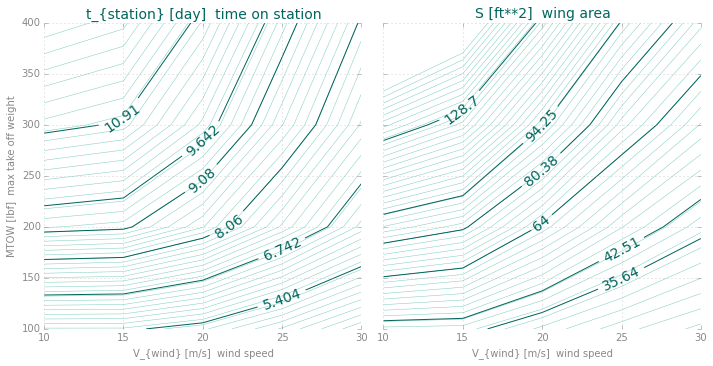

In [38]:
%matplotlib inline
from gpkit.interactive.plotting import contour_array
_ = contour_array(M, "V_{wind}", "MTOW", ["t_{station}", "S"])